# Lab 2 QIC

In [190]:
!pip install qiskit qiskit-aer seaborn numpy matplotlib

In [191]:
import qiskit.tools.jupyter
%qiskit_version_table

In [1]:
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector,plot_bloch_multivector
import numpy as np

## Quantum Algorithms

As presented in[1], quantum computers are designed with the aim of surpassing conventional computers in different key areas that include cryptography, search and optimization, simulation of quantum systems, and solving large systems of linear equations. Hence, quantum computers hold the potential to facilitate the execution of novel algorithms that would have demanded substantial computational resources on a classical computer. According to[2], there are 3 categories of quantum algorithms that exhibit superior efficiency compared to their classical counterparts:

1. Simulation algorithms employed for quantum system simulations on quantum computers.
2. Algorithms based on quantum Fourier Transform, like Shor's algorithm[3] and Deutsch-Jozsa's[5] algorithm.
3. Search algorithms, exemplified by Grover's algorithm[4].

According to[6] all quantum algorithms share a common basic framework, with several variations:

1. The algorithm starts with the qubits in a particular classical state.
2. A superposition of many states is created.
3. Applied several unitary operations that act on this superposition.
4. Measurement of the qubits.


### Grover's algorithm

$$
\mathcal{O} (\sqrt{N})
$$
where $N = 2^m$, N is the search space size and m is the number of qubits in circuit.



1. create a superposition
2. Apply the oracle
3. apply a diffusion operator $\sqrt{N}$ times

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
qc = QuantumCircuit(4)

qc.h(3)

qc.x(0)
qc.x(1)

qc.mct([0,1,2],[3])
qc.x(0)
qc.x(1)
qc.h(3)
oracle = qc.to_gate()
oracle.name = "U$_\omega$"

In [4]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits-1):
        qc.h(qubit)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits-1):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-2)
    qc.mct(list(range(nqubits-2)), nqubits-2)  # multi-controlled-toffoli
    qc.h(nqubits-2)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits-1):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    qc.draw(output="mpl")
    return U_s

In [5]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

4.0


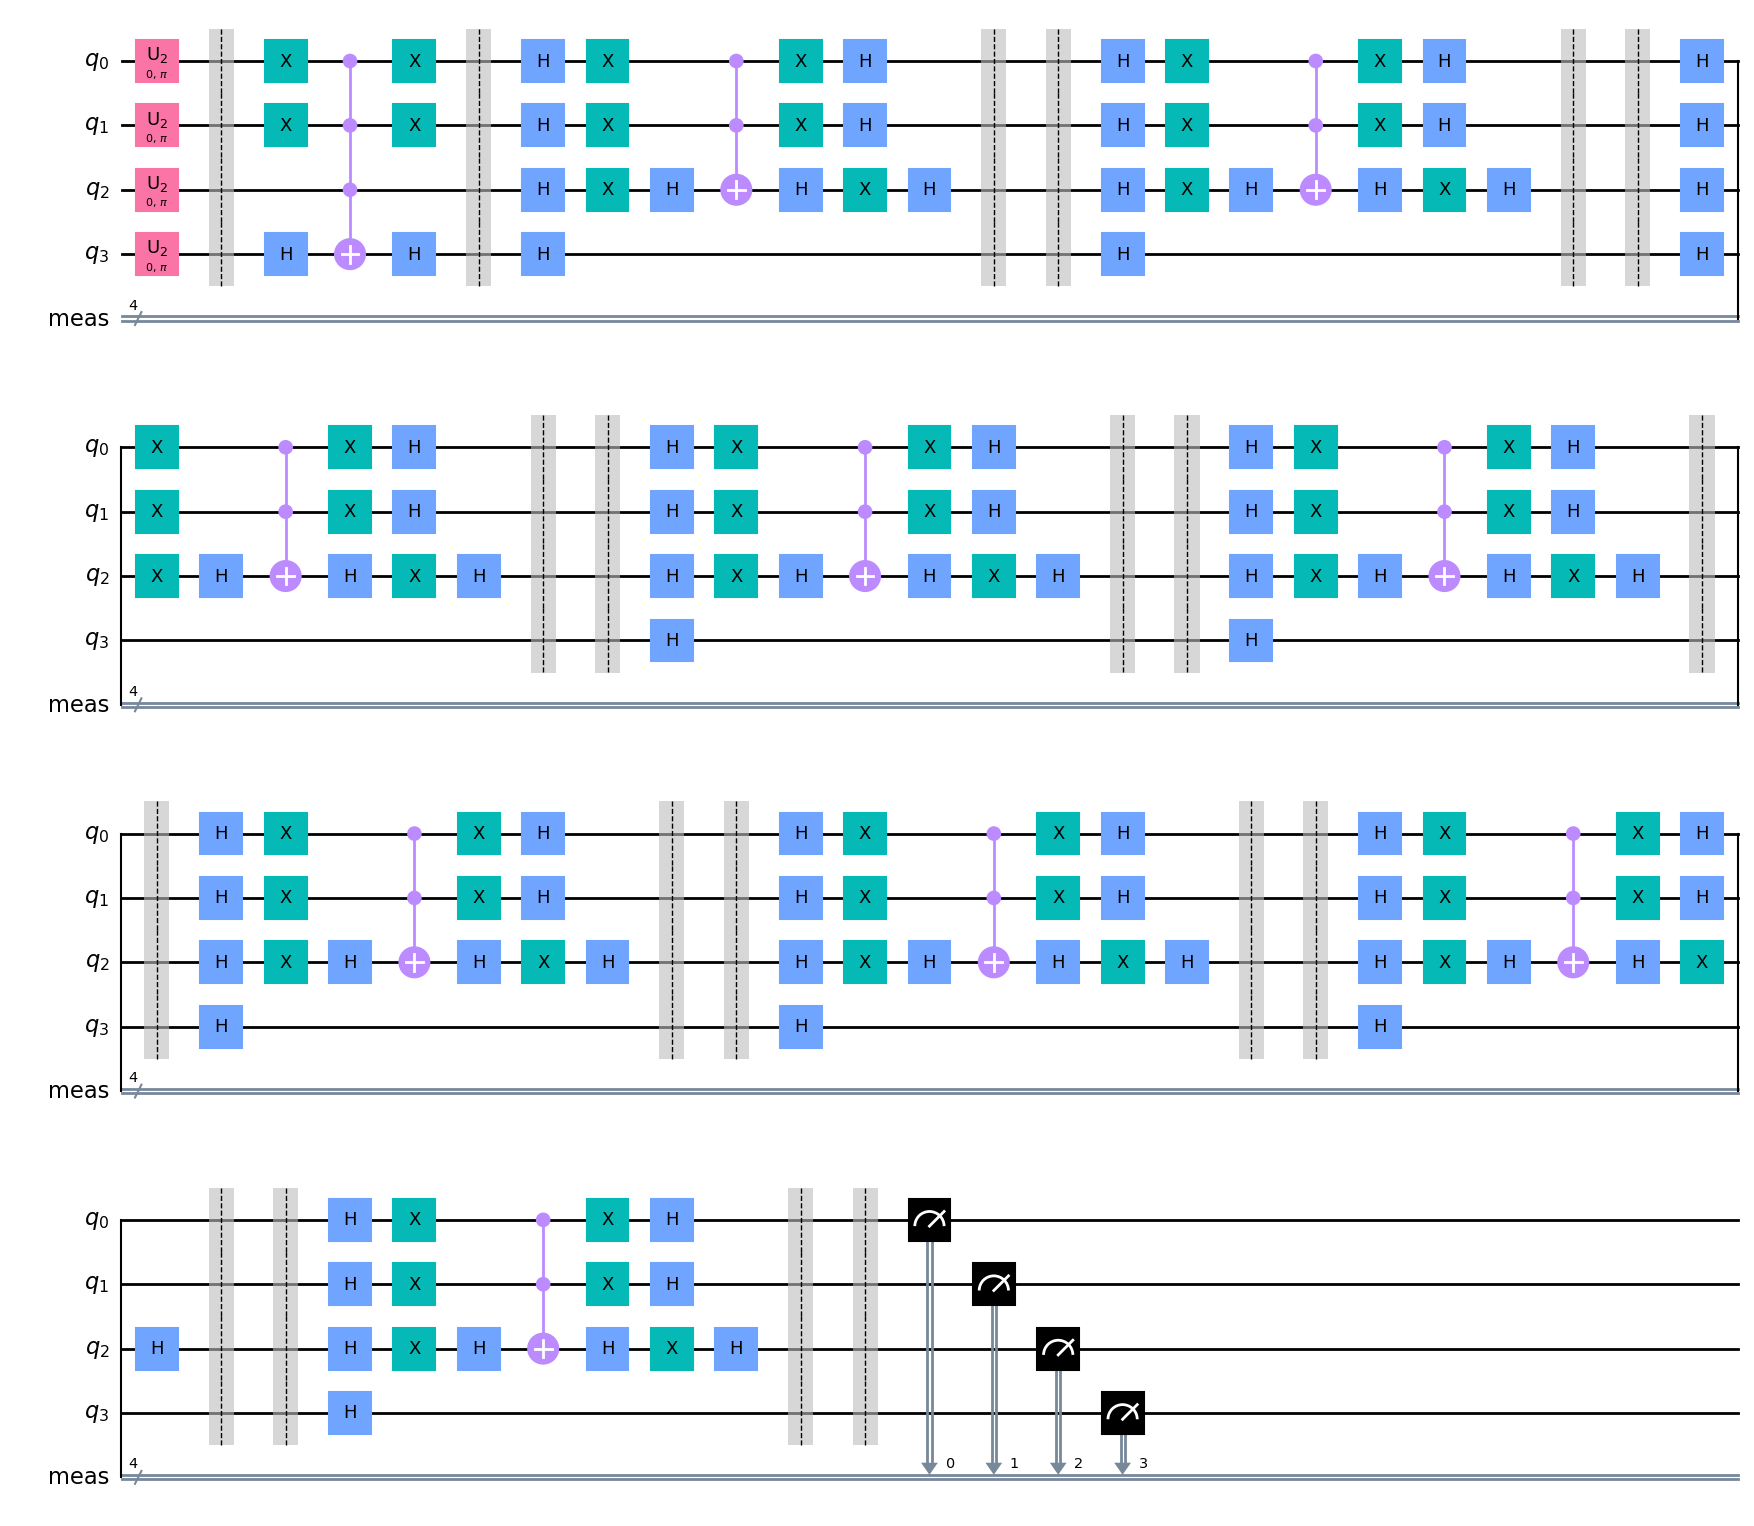

In [7]:
import math
n = 4 # N = 4 search space

qc = QuantumCircuit(n)
# |000>
qc = initialize_s(qc,[i for i in range(0,n)])

qc.barrier()
qc.append(oracle, [0,1,2,3])

m = math.sqrt(2**n)
print(f"{m}")
for i in range(0,9):
    qc.barrier()
    qc.append(diffuser(n), [0,1,2,3])
    qc.barrier()
qc.measure_all()
decomposed_circ = qc.decompose() # Does not modify original circuit
decomposed_circ.draw(output="mpl")



In [8]:
sv_sim = Aer.get_backend('statevector_simulator')
transpiled_grover_circuit = transpile(qc, sv_sim)
result = sv_sim.run(transpiled_grover_circuit).result()
statevec = result.get_statevector()
from qiskit.visualization import array_to_latex
array_to_latex(statevec, prefix="|\\psi\\rangle =")

<IPython.core.display.Latex object>

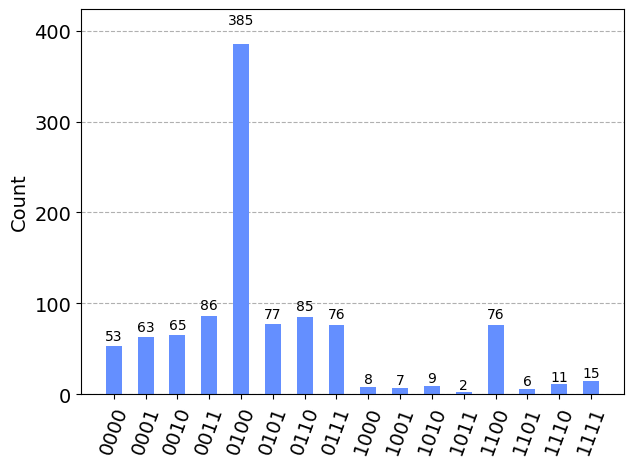

In [9]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(qc, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

### Deutsch's algorithm



Let's consider a function $f:\{0,1\} \rightarrow \{0,1\}$, $f$ is balanced if $f(0) \neq f(1)$ and constant if $f(0) = f(1)$. Thus, of the 4 functions, two are balanced and 2 are constant.

![Deutsch's Algorithm](./data/deutsch.png)


The algorithm solves the following problem: Considering the above-mentioned function as a black box, determine if the function is balanced or constant. On a classical computer, the problem can be solved by evaluating the function twice, thus, calling $f(x)$ twice.
Considering that such a function can be thought of as a matrix acting on the input, we can then define the following matrices (column name is to be thought as the input and the row name as the output):

1. $f(0) = 1,f(1) = 0$

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 1 |
| 1 | 1 | 0 |

2. $f(0) = 0, f(1) = 1$

|   | 0 | 1 |
|---|---|---|
| 0 | 1 | 0 |
| 1 | 0 | 1 |

3. $f(0) = 0, f(1) = 0 $

|   | 0 | 1 |
|---|---|---|
| 0 | 1 | 1 |
| 1 | 0 | 0 |

4. $f(0) = 1, f(1) = 1$

|   | 0 | 1 |
|---|---|---|
| 0 | 0 | 0 |
| 1 | 1 | 1 |
me).




On a quantum computer, we use the superposition to evaluate both inputs at one time (basically since the quantum state is in a superposition of the two basic states at the same time).

![Deutsch's Algorithm](./data/deutsch_circuit.png)

where $\ket{x}$ is the qubit value that we wish to evaluate and $\ket{y}$ controls the output. As output, we will have $\ket{x}$ and $\ket{y \oplus f(x)}$. Thus, considering that $y=0$, then $U_f$ performs the mapping $\ket{x,0} \rightarrow \ket{x, 0 \oplus f(x)}=\ket{x,f(x)}$

Thus, for each function we shall define the unitary matrices that correspond to $U_f$:


$f(0) = 1,f(1) = 0$

|    | 00 | 01 | 10 | 11 |
|----|----|----|----|----|
| 00 | 0  | 1  | 0  | 0  |
| 01 | 1  | 0  | 0  | 0  |
| 10 | 0  | 0  | 1  | 0  |
| 11 | 0  | 0  | 0  | 1  |


$f(0) = 0, f(1) = 1$


|    | 00 | 01 | 10 | 11 |
|----|----|----|----|----|
| 00 | 1  | 0  | 0  | 0  |
| 01 | 0  | 1  | 0  | 0  |
| 10 | 0  | 0  | 0  | 1  |
| 11 | 0  | 0  | 1  | 0  |


$f(0) = 0, f(1) = 0$


|    | 00 | 01 | 10 | 11 |
|----|----|----|----|----|
| 00 | 1  | 0  | 0  | 0  |
| 01 | 0  | 1  | 0  | 0  |
| 10 | 0  | 0  | 1  | 0  |
| 11 | 0  | 0  | 0  | 1

 $f(0) = 1, f(1) = 1$


|    | 00 | 01 | 10 | 11 |
|----|----|----|----|----|
| 00 | 0  | 1  | 0  | 0  |
| 01 | 1  | 0  | 0  | 0  |
| 10 | 0  | 0  | 0  | 1  |
| 11 | 0  | 0  | 1  | 0  | 1  | f(1) = 1$1  |


In [10]:
def uf0(qcirc):
    qcirc.cx(0,1)
    qcirc.barrier()
    return qcirc

def uf1(qcirc):
    qcirc.x(1)
    qcirc.cx(0,1)
    qcirc.barrier()
    return qcirc

def uf2(qcirc):
    qcirc.barrier()
    return qcirc

def uf3(qcirc):
    qcirc.x(1)
    return qcirc

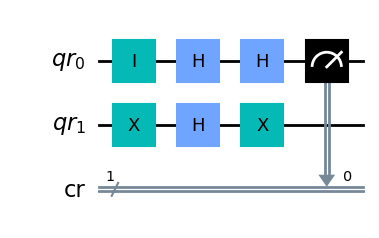

In [11]:
qr = QuantumRegister(2, 'qr')
cr = ClassicalRegister(1, 'cr')
qc = QuantumCircuit(qr,cr)
qc.i(0)
qc.x(1)

qc.h([0,1])
qc = uf3(qc)

qc.h(0)
qc.measure(qr[0],cr)
qc.draw('mpl')

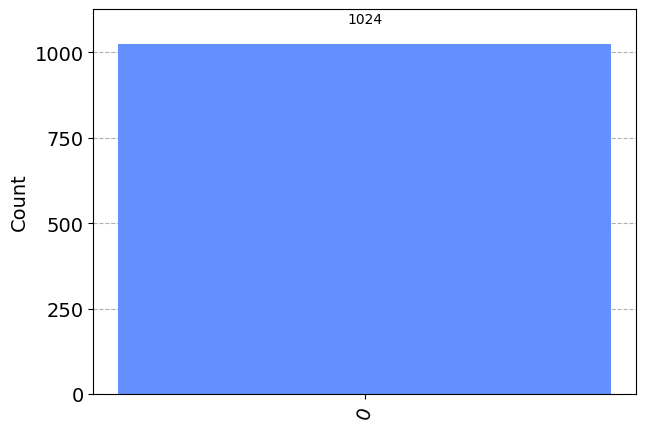

In [12]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(qc, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

## Bibliography

[1] MONTANARO, Ashley. Quantum algorithms: an overview. npj Quantum Information, 2016, 2.1: 1-8.

[2] NIELSEN, Michael A.; CHUANG, Isaac L. Quantum computation and quantum information. Cambridge university press, 2010.

[3] SHOR, Peter W. Algorithms for quantum computation: discrete logarithms and factoring. In: Proceedings 35th annual symposium on foundations of computer science. Ieee, 1994. p. 124-134.

[4] GROVER, Lov K. A fast quantum mechanical algorithm for database search. In: Proceedings of the twenty-eighth annual ACM symposium on Theory of computing. 1996. p. 212-219.

[5] DEUTSCH, D. Rapid solution of problems by quantum computation. Proc. Royal Society A, 1991, 435: 563-574.

[6] YANOFSKY, Noson S.; MANNUCCI, Mirco A. Quantum computing for computer scientists. Cambridge University Press, 2008.